In [1]:
from scipy.io.wavfile import read
import numpy as np
from matplotlib import pyplot as plt
from scipy import signal, stats
import pytest
import math
import ipytest
import cProfile
from cmath import *
ipytest.config(rewrite_asserts=True, magics=True)
__filename__ = "XC"

/Users/kitty/miniconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
def stereo_to_mono(audio):
    return audio.sum(axis=1) / 2

In [3]:
frq, raw_sample = read("oblivion.wav")
original = stereo_to_mono(raw_sample)

In [4]:
frq, raw_sample = read("oblivion.cut.wav")
sample = stereo_to_mono(raw_sample)

In [5]:
noise = np.random.normal(0, 1, sample.shape)
len(noise)

959488

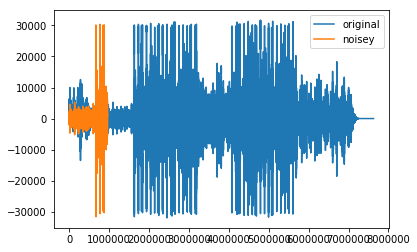

In [6]:
original_l, = plt.plot(original, label="original")
sample_l, = plt.plot(sample + noise, label="noisey sample")
plt.legend([original_l, sample_l], ["original", "noisey"])
plt.show()

In [138]:
class AudioClip(object):
    def __init__(self, data, frq):
        self.data = data
        self.frq = frq
        
    def __get_item__(self, i):
        return self.data[i]
    
    def low_pass(self, cutoff_frq, nyq_freq, order=4):
        normal_cutoff = float(cutoff_frq) / nyq_freq
        b, a = signal.butter(order, normal_cutoff, btype='lowpass', output='ba')
        y = signal.filtfilt(b, a, self.data)
        self.data = y
    
    def filter_and_downsample(self, ds_factor=4):
        self.data = signal.decimate(self.data, ds_factor, n=4)
        self.frq = self.frq / ds_factor
    
#     def create_window(self, bin_num, total_width, seconds=0.1):
#         bin_size = int(self.frq * seconds)
#         frame = np.hanning(bin_size)
#         left_pad = np.zeros(bin_num * bin_size)
#         right_pad = np.zeros(total_width - ((bin_num + 1) * bin_size))
#         window = np.concatenate((left_pad, frame, right_pad), axis=0)
#         return window
    
#     def apply_window(self, bin_num):
#         window = self.create_window(bin_num, len(data))
#         return self.data * window
    
#     def zero_pad(self, records):
#         x = len(records)
#         zeroes = pow(2, math.ceil(math.log(x) / math.log(2))) - x
#         return np.concatenate((records, [0] * zeroes))
    def get_snippet(self, bin_num, bin_size):
        # For sampling frequency 12kHz and 0.1s window
        # bin 0 should return 0 through 1199
        # bin 1 should return 1200 through 2400
        idx = bin_num * bin_size
        snippet = self.data[idx:idx+bin_size]
        assert len(snippet) == bin_size
        return snippet
    
    def multiply_hanning(self, snippet, bin_size):
        # Hanning window starts and ends at 0
        # plt.plot(np.hanning(bin_size) * np.array(snippet))
        return np.hanning(bin_size) * np.array(snippet)
    
    def create_frequencies_array(self, bin_seconds=0.1):
        bin_size = int(self.frq * bin_seconds)
        num_bins = len(self.data) // bin_size
        results = []
        windowed_snippets = []
        reals = []
        for b in range(num_bins):
            # values = apply_window(data, frq, bin_num)
            # padded_values = zero_pad(values)
            # padding gives you better resolution, but too expensive
            # more spectral leakage w/o padding
            snippet = self.get_snippet(b, bin_size)
            windowed_snippet = self.multiply_hanning(snippet, bin_size)
            windowed_snippets.append(windowed_snippet)
            magnitude = [abs(x) for x in np.fft.fft(windowed_snippet)]
            results.append(magnitude)
            real = [x.real for x in np.fft.fft(windowed_snippet)]
            reals.append(real)
            print(b)
        return results, windowed_snippets, reals
    
    def __str__(self):
        return "Size %d sampled at %d Hz" % (len(self.data), self.frq)

In [139]:
ac = AudioClip(original, frq)
print(ac)
ac.low_pass(5000, 2 * 5000) # Cut at 5kHz
ac.filter_and_downsample()

Size 7627232 sampled at 48000 Hz


/Users/kitty/miniconda3/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/Users/kitty/miniconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


In [140]:
print(ac)

Size 1906808 sampled at 12000 Hz


In [142]:
results, windowed_snippets, reals = ac.create_frequencies_array()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1589 1200


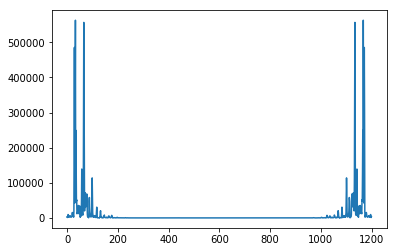

In [131]:
# Frequency went from 44.1kHz to 11.025kHz
print(len(results), len(results[0]))
np.mean(results[1500])
plt.plot(results[701])

In [143]:
import matplotlib.animation as animation
from matplotlib.animation import PillowWriter
def create_gif(file, title, results):
    ims = []
    fig = plt.figure()
    plt.gca().set_title(title)
    for result in results:
        ims.append(plt.plot(result))
    ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=500, repeat=True)
    writer = PillowWriter(fps=50)
    ani.save(file, writer=writer)
    plt.show()

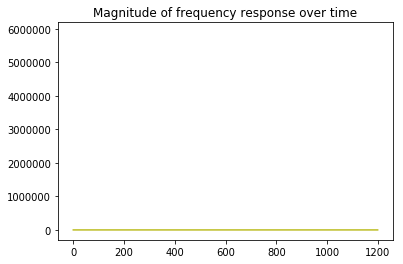

In [145]:
create_gif("magnitude.gif", "Magnitude of frequency response over time", results)

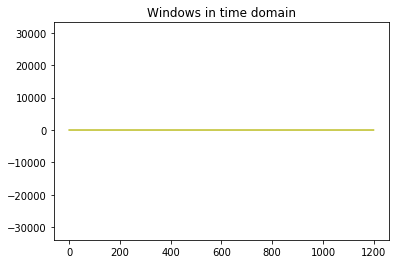

In [146]:
create_gif("windowed.gif", "Windows in time domain", windowed_snippets)

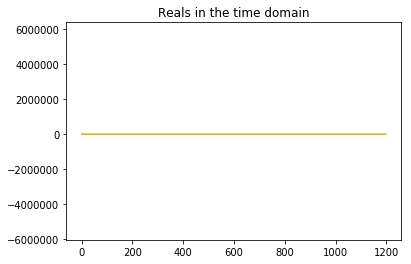

In [144]:
create_gif("reals.gif", "Reals in the time domain", reals)